In [1]:
# plotting libraries

# for inline plots in jupyter
if True:
    %matplotlib inline
else:
    %matplotlib notebook
        
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from IPython.display import Math, Latex
from IPython.core.display import Image
import scipy.integrate as integrate

######################### Utilities functions ########################333


def combine_edges( counts, edges, threshold ):
    '''Manipulate a histogram of data merging bins whose counts are less than
    a given threshold
    
    Example:
        import nump as np
        
        counts, edges  = np.histogram (sample_post, bins=20, density=False)
        c, e = combine_edges (count, edges, 6)
    '''
    
    max_ix = counts.argmax()
    c_list = list( counts )   # Lists can be popped from
    e_list = list( edges )    # Lists can be popped from

    def eliminate_left( ix ):
        # Sum the count and eliminate the edge relevant to ix
        # Before the peak (max_ix)
        nonlocal max_ix
        max_ix -= 1         # max_ix will change too.
        c_list[ix+1]+=c_list[ix]
        c_list.pop(ix)
        e_list.pop(ix+1)

    def eliminate_right( ix ):
        # Sum the count and eliminate the edge relevant to ix
        # after the peak (max_ix) 
        c_list[ix-1]+=c_list[ix]
        c_list.pop(ix)
        e_list.pop(ix)

    def last_lt():
        # Find the last ix less than the threshold
        for ix, ct in zip( range(len(c_list)-1, max_ix, -1), c_list[::-1]):
            # ix reduces from len(c_list)-1, c_list is accessed in reverse order.
            if ct < threshold:
                return ix
        return -1  # If no items < threshold return -1

    cont = True

    def first_lt():
        result = -1  # Set default
        for ix, ct in enumerate( c_list[:max_ix] ):
            if ct < threshold:
                result = ix  # If ct < threshold set result to ix
            break        # Break out of the loop
        return result

    cont = True
    while cont:
        # Each iteration removes any counts less than threshold
        # before the peak.  This process would combine e.g. counts of [...,1,2,3,...] into [..., 6, ...]
        ix = first_lt()
        if ix < 0:
            cont = False   # If first_lt returns -1 stop while loop
        else:
            eliminate_left( ix )

    cont = True
    while cont:
        ix = last_lt()
        if ix < 0:
            cont = False   # If last_lt returns -1 stop while loop
        else:
            eliminate_right( ix )

    return np.array( c_list ), np.array( e_list )


def get_bin_probabilities (distribution, args, edges) :
    cdf = distribution.cdf (e,*H0_args)
    prob = cdf[1:] - cdf[:-1]
    prob[-1] = prob[-1] + (1-cdf[-1])
    prob[0]  = prob[0] + cdf[0]
    return prob

**Aplicación de Métodos de Monte Carlo a la Computación Bayesiana**

# Inferencia Bayesiana (Teorema de Bayes)

En un *enfoque bayesiano* de la estadística, un parámetro $\theta$ se considera una variable aleatoria con una determinada distribución de probabilidad.
El teorema de Bayes relaciona la información inicial que se tiene del parámetro $\theta$ antes de realizar un experimento y la información que se dispone de él después de realizar el experimento.   

* La información inicial que se tiene sobre $\theta$ se representa mediante su *distribución a priori,*  $\pi(\theta)$.

* La información que se tiene de $\theta$ después de realizar uno (o varios) experimento/s, $x$, se codifica mediante su *distribución a posteriori*  $\pi(\theta | x)$. 

* El teorema de Bayes nos permite obtener la densidad de probabilidad $\pi(\theta | x)$ en función del resultado del experimento y la densidad de probabilidad a priori $\pi(\theta)$. Es, por tanto, un **método general de inducción** o de **aprendizaje a partir de la experiencia:**
  $$\texttt{a priori} \rightarrow \texttt{datos} \rightarrow \texttt{a posteriori}$$

$$
\pi(\theta | x) = \frac{ \pi(x | \theta) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta} 
\; \pi(\theta)
$$

* La cantidad  $\pi(x | \theta)$ del numerador se denomina *verosimilitud* (*likelihood*). Es una **función**  proporcional a la probabilidad de observar el resultado del experimento $x$ (muestra) _para un valor dado_ del parámetro $\theta$

    $$
    \pi(x | \theta) = \prod_i f(x_i | \theta) 
    $$

    siendo $x_i$ con $i=1, \ldots, n$ los resultados del experimento (valores muestrales) y  $f(x_i | \theta)$ sus probabilidades para un determinado valor de $\theta$. (_Como de versomil, esto es, probable, era observar el experimento $x$ dado el valor concreto de $\theta$_)

* El denominador $ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta$, una vez realizada la integración, **obviamente no** depende del parámetro $\theta$. Es una constante de normalización para que la integral de $f(\theta|x)$ sea la unidad.
  No proporciona, por tanto, ninguna información adicional sobre la distribución a posteriori.
  Algunos autores la denominan **verosimilitud marginal** (o ponderada) ya que es una ponderación de las funciones $f(x|\theta)$ cuyos coeficientes de ponderación (el peso dado a cada valor  $\theta$) están dados por la distribución a priori $\pi (\theta)$. 

* Para realizar previsiones se utilizan *distribuciones predictivas* (valor esperado de una determinada función)

    $$
    E[ g(y|x) ] = \int g(y| \theta) \;  \pi(\theta | x)  \; d\theta
    $$

    Por ejemplo, es habitual usar como *predictor* del valor de la v.a $\theta$ su valor esperado:
$$
\widehat{\theta} = \int \theta \;  \pi(\theta | x)  \; d\theta
$$

* Cuando las distribuciones a priori y a posteriori pertenecen a la misma familia se dice que son **_conjugadas a priori_**. A menudo esto implica grandes beneficios desde el punto de vista computacional. 
* La descripción formal de la inferencia bayesiana es sencilla, sin embargo su implementación **habitualmente no es fácil** y requiere Métodos de Monte Carlo. 

# Ejercicio 1

<div class="alert-warning">


Estimar la probabilidad de que un paciente ingresado en planta acabe en la UCI. 

Para realizar este problema mediante inferencia Bayesiana debemos tener en cuenta:

* La probabilidad de que un paciente ingresado en planta acabe en la UCI será nuestro parámetro $\theta$. Como hemos visto, en el enfoque bayesiano debemos considerar que $\theta$ es una variable aleatoria.

* Debemos conocer la distribución de la v.a $\theta$ **antes** de realizar el experimento, es decir su *densidad de probabilidad a priori* $\pi(\theta)$. Supongamos, por ejemplo, que $\pi(\theta)$ se distribuye según una distribución Beta, $\pi(\theta) = B(\theta | \alpha = 5, \beta = 10)$.


* En el enfoque bayesiano debemos **incorporar la información que nos aporta el resultado de un experimento**. Considerad el siguiente experimento: se contabiliza cuantos de los pacientes que había en planta, $n$, han debido ingresar en la UCI, $k$, después de un determinado periodo de tiempo. Se observa que de los $n=20$ pacientes, uno, $k=1$, debió ingresar en la UCI. 

    * Debemos calcular la función de verosimilitud  $\pi(x | \theta)$ del resultado del experimento. La función de verosimilitud será proporcional a la probabilidad de observar el resultado del experimento en función del valor de $\theta$: 

    $$
    \pi(x | \theta) \propto \theta^k (1-\theta)^{n-k} 
    $$
    
    donde, en nuestro experimento, $n=20$ y $k=1$. Notad como en la ecuación anterior $\pi(x|\theta)$ **no** está normalizada. 
    

* Debemos elegir un *predictor* adecuado a nuestro problema. Como predictor de $\theta$ *la probabilidad de que un paciente de la planta acabe en la UCI* utilizaremos su valor esperado $E[\theta]$. Nos preguntarnos entonces:

    1. ¿Cuál es el valor de $E[\theta]$ **antes** de realizar el experimento? 
    2. ¿Cuál es el valor de $E[\theta]$ **después** de observar el resultado del experimento? 
    
 </div>
 

 **Ayuda:**
 
 * Recuerda la distribución  $Beta(\theta| \alpha, \beta)$:
   \begin{align}
   Beta(\theta| \alpha, \beta) & = \frac{1}{B(\alpha, \beta)} \theta^{\alpha -1} (1-\theta)^{\beta -1}
   \end{align}
   donde $B(\alpha, \beta)$ es la constante de normalización, cuyo valor s , en este caso, la función beta:
   \begin{align}
   B(\alpha, \beta) & = \frac{\Gamma (\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)}
   \end{align}
  Observar que la distribución uniforme, $U(0, 1)$, es un caso particular de la distribución $Beta$ cuando $Beta(\theta| \alpha=1, \beta=1)$:

 * La pregunta (1) es fácil. Al ser la distribución a priori $\pi(\theta)$ la distribución $Beta$, su valor esperado será
 $$
 \mu_{\text{prior}} = E[\theta]_{\text{prior}} = \int_{-\infty}^{\infty} \theta  \; B(\theta | \alpha, \beta) \;  d\theta =  \frac{\alpha}{\alpha + \beta}
 $$
 
 * Para la pregunta (2) se debe calcular: 
 $$
 \mu_{\text{posterior}}= E[\theta]_{\text{posterior}} = \int_{-\infty}^{\infty} \theta \;  \pi(\theta | x)  \; d\theta 
 $$
    Para ello se necesita conocer la distribución a posteriori $\pi(\theta | x)$. Utilizando el teorema de Bayes, tras re-ordenar términos se obtiene:
    \begin{align}
 E[\theta]_{\text{posterior}} &= 
 \int_{-\infty}^{\infty} \theta \;  \pi(\theta | x)  \; d\theta \\
                 &= \int_{-\infty}^{\infty} \theta \;     
\frac{ \pi(x | \theta) \; \pi(\theta) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta} 
  \;  d\theta  = 
  \frac{ \int_{-\infty}^{\infty} \theta  \; \pi(x | \theta) \; \pi(\theta) \;  d\theta }
       { \int_{-\infty}^{\infty}            \pi(x | \theta) \; \pi(\theta) \; d\theta} \\
 &= \frac{\int_{-\infty}^{\infty} \theta  \; \theta^k (1-\theta)^{n-k}  \; \; \pi(\theta) \; d\theta }
 { \int_{-\infty}^{\infty}  \pi(x | \theta) \; \pi(\theta) \; d\theta}  =
 \frac{ \int_{0}^{1}  \; \theta^{k+1} (1-\theta)^{n-k}  \; \; B(\theta| \alpha=5, \beta=10) \; d\theta }
 { \int_{0}^{1}   \theta^{k} (1-\theta)^{n-k} \; B(\theta| \alpha=5, \beta=10) \; d\theta} 
   \end{align}
  donde se han substiuído los valores de $\pi(\theta)$ y de la verosimilitud $\pi(x|\theta)$.
  
   Sino supiésemos resolver analíticamente las integrales anteriores (en este caso sí hay solución analítica aunque no es fácil) podemos **estimar** el numerador y el denominador mediante integración de Monte Carlo.

## Solución analítica: aplicación teorema de Bayes

En el problema se sugiere utilizar una estrategia de Monte Carlo para estimar el valor esperado de la distribución de probabilidad *a posteriori* de $\theta$, siendo $\theta$ la probabilidad de que un paciente en planta ingrese en la UCI. 

En realidad, en este problema, **no** es necesario utilizar Monte Carlo. 

Cuando la distribución *a priori* $\pi(\theta)$ es una distribución $Beta (\theta|\alpha, \beta)$ y la función de verosimilitud $\pi(x| \theta)$ está dada por (5), la distribución *a posteriori* $\pi(\theta| x)$  tiene una *expresión cerrada*.
En este caso $\pi(\theta| x)$ es también una distribución $Beta$ (se dice que ambas son *conjugadas a priori*) de parámetros $\alpha'$ y $\beta'$ donde $\alpha' = \alpha +k$ y $\beta'=\beta + (n-k)$. 
Es decir, el parámetro $\alpha$ de la distribución a priori se incrementa en $k$ (el número de éxitos del experimento) y el parámetro $\beta$ en $n-k$ (el número de fracasos).

En la gráfica siguiente se representan las distribuciones *a priori, a posteriori* y *verosimilitud* para los valores propuestos por el problema, $ \pi(\theta) = Beta(\theta|\alpha=5,\beta=10)$ $n=20$ y $k=1$.




Expected probability a priori: 0.333 
Expected probability a posterior: 0.171
Maximum likelihood: 0.050
Experimento: 
 Total pacientes:20  UCI:1


NameError: name 'scipy' is not defined

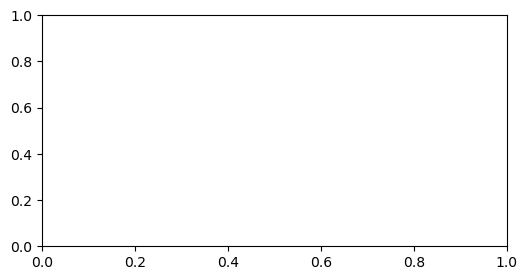

In [2]:
# a priori knowledge (Beta distribution)
a, b = 5, 10                                                   # alpha y beta de la distribucion Beta
mu = lambda a_, b_ : a_ / (a_ + b_)                            #  mean Beta distribution
sigma2 = lambda a_, b_: (a_*b_) / (((a_+b_)**2) * (a_+b_+1))   # Variance Beta distribution

# Experiment results
n_exp = 20
exitos_exp = 1  

fracasos_exp = n_exp - exitos_exp  # valor 0

# Posterior
a_posterior =  a + exitos_exp 
b_posterior = b + fracasos_exp
mu_posterior = mu(a_posterior, b_posterior)

print(f'Expected probability a priori: {mu(a, b):.3f} ')
print(f'Expected probability a posterior: {mu(a_posterior, b_posterior):.3f}')
print(f'Maximum likelihood: {exitos_exp / n_exp:.3f}')
print(f'Experimento: \n Total pacientes:{n_exp}  UCI:{exitos_exp}')


# Verosimilitud
likelihood_prop = lambda theta, k, n: np.power(theta, k) * np.power(1-theta, n-k)

def likelihood(theta, k, n):
    '''Likelihood pdf (likelihood_prop lambda function normalized) '''
    int_num = integrate.quad(likelihood_prop, a=0, b=1, args=(k, n))  
    y = likelihood_prop(theta, k, n) / int_num[0]
    return y


#Polt a priori,  posteriori and likelihood
x_size = 1000
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.linspace(0, 1, x_size)
pi_prior = scipy.stats.beta.pdf(x, a, b)
pi_posterior =  scipy.stats.beta.pdf(x, a_posterior, b_posterior)
verosi = likelihood(x, exitos_exp, n_exp) 
 
ax.plot (x, pi_prior, 'b-', lw=1, alpha=0.6, label=r'prior, $\pi(\theta)$') 
ax.plot (x, pi_posterior, 'r-', lw=1, alpha=0.6, label=r'posterior, $\pi(\theta | x)$') 
ax.plot (x, verosi, 'g-', lw=1, alpha=0.6, label=r'likelihood, $\pi(x|\theta)$') 
ax.set_xlabel (r'$\theta$, prob paciente planta --> UCI')

ax.legend(loc='best', frameon=True)

plt.show()

Como se observa la distribución a *posteriori* es un compromiso entre la distribución a priori (el conocimiento del que dispongo **antes** de realizar el experimento) y la *verosimilitud* (el conocimiento que me aporta *exclusivamente* el resultado del experimento).

En el caso particular en que $\pi(\theta)$ fuese aproximadamente constante sobre el rango de valores de $\theta$ en los que la verosimilitud no fuese nula, la _posteriori_ sería simplemente la función de verosimilitud. En este caso se dice que $\pi(\theta)$ es **no informativa**.

**Ejercicio:** Analiza el caso en $\pi(\theta)$ fuese una distribución $Beta(\alpha=1, \beta=1)$

En el problema estamos interesados en hallar el valor esperado de la v.a $\theta$ para las distribuciones *a priori* y *a posteriori*. O lo que es lo mismo, debemos hallar el valor esperado de una v.a aleatoria que se distribuye según una $Beta (\theta |\alpha, \beta)$ de parámetros conocidos. Se puede demostrar que

$$
\mu = E[\theta] := \int_0^1 \theta \; B(\theta | \alpha, \beta) \; d\theta = \frac{\alpha}{\alpha + \beta}
$$

**¿Qué ocurre cuando aumenta el tamaño del experimento?**

En la gráfica siguiente se ha incrementado la muestra del experimento, $n=100$, pero manteniendo el ratio $k/n=0.05$ del experimento original

In [ ]:

# pi_a priori knowledge
a, b = 5, 10
mu = lambda a_, b_ : a_ / (a_ + b_)                               # Valor esperado distribucion Beta
sigma2 = lambda a_, b_: (a_*b_)/( ((a_+b_)**2) * (a_+b_+1)  )     # Varianza distribución Beta

# Experiment results
MUL = 5
n_exp = 20*MUL                                                    # Éxitos experimento
exitos_exp = 1*MUL                                                # Total en experimento
fracasos_exp = n_exp - exitos_exp                               

# Posterior
a_posterior =  a + exitos_exp           
b_posterior = b + fracasos_exp
mu_posterior = mu(a_posterior, b_posterior)                       # valor esperadp


print(f'Expected probability a priori: {mu(a, b):.3f} ')
print(f'Expected probability a posterior: {mu(a_posterior, b_posterior):.3f}')
print(f'Maximum likelihood: {exitos_exp / n_exp:.3f}')
print(f'Experimento: \n Total pacientes:{n_exp}  UCI:{exitos_exp}')

# Plot a priori,  posteriori and likelihood
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.linspace(0, 1, 1000)
pi_prior = scipy.stats.beta.pdf (x, a, b)
pi_posterior =  scipy.stats.beta.pdf (x, a_posterior, b_posterior)
verosi = likelihood (x, exitos_exp, n_exp) 
 
ax.plot (x, pi_prior, 'b-', lw=1, alpha=0.6, label=r'prior, $\pi(\theta)$') 
ax.plot (x, pi_posterior, 'r-', lw=1, alpha=0.6, label=r'posterior, $\pi(\theta | x)$') 
ax.plot (x, verosi, 'g-', lw=1, alpha=0.6, label=r'likelihood, $\pi(x|\theta)$') 
ax.set_xlabel (r'$\theta$, prob paciente planta --> UCI')

ax.legend(loc='best', frameon=True)

plt.show()


Algunas consecuencias interesantes que se derivan de la expresión analítica de $\pi(\theta | x)$:

* Al ser $\pi(\theta|x)$ también una distribución Beta, el **valor esperado de $\theta$ a posteriori**, i.e., después de observar el resultado del experimento, es  
$$
\mu_{\text{posterior}} = E \left[ \theta | x \right]  
= \frac{\alpha'}{\alpha' + \beta'} = \frac{\alpha + k}{\alpha +k + \beta + n - k} =   \frac{\alpha + k}{\alpha + \beta + n}
$$
  Teniendo en cuenta que el **valor esperado de la distribución a priori** $\pi(\theta)$ es:
$$
\mu_{\text{priori}}=  E \left[ \theta \right]   = \frac{\alpha}{\alpha + \beta}
$$
y el **valor de $\theta$ para el que la verosimilitud es máxima** $\theta_{MLE} = k/n$ (ver _Recordatorio_ siguiente), podemos expresar el valor esperado a posteriori como la media ponderada del valor esperado de
nuestras creencias a priori y la estimación de máxima verosimilitud
$$
\mu_{\text{posterior}} = \frac{\alpha + k}{\alpha + \beta + n } =
\frac{\alpha + \beta}{\alpha + \beta + n } \; \mu_{\text{priori}} +
\frac{n}{\alpha + \beta + n } \; \theta_{MLE}
$$

* Cuando el número de pacientes del experimento es muy grande, $n, k \to \infty$, $\mu_{\text{posterior}}$ converge al valor de máxima verosimilitud (MLE) $k/n$. Es decir, cuando $n \to \infty$, **el *conocimiento a priori* es irrelevante frente a la información que aporta el experimento.** 

* **La *incertidumbre* en torno al valor esperado $\mu_{\text{posterior}}$ decrece con $n \to \infty$** 

$$
\sigma^2 = \lim_{n \to \infty} \frac{ \alpha' \beta'}{ (\alpha' + \beta')^2 (\alpha' + \beta' +1) } = \frac{k n -k^2}{n^3} = 0
$$

* Una introducción _breve_ a distribuciones conjugadas https://halweb.uc3m.es/esp/Personal/personas/causin/esp/2012-2013/SMB/Tema6.pdf

<div class="alert-success">

**Recordatorio:**    

El valor máximo de la verosimilitud MLE de una v.a $\theta$ es el valor de $\theta$ para el cúal la función de verosimilitud es máxima
$$
\theta_{MLE} = \text{argmax}_{\theta} \pi(x | \theta)
$$
    
Habitualmente se calcula maximizando el logarítmo de $\pi(x|\theta)$
    $$
    \frac{\partial}{\partial \theta} log (\pi (x | \theta) ) = 0
    $$

Para este problema, en el que $\pi(x| \theta)$ está dada por la ecuación (5) 
    $$
     \frac{\partial }{\partial \theta}\left( k log (\theta ) + (n-k) \log(1-\theta) \right) = 0
    $$
    se obtiene $\theta_{MLE}$ = k/n  
    
    

## Simulación  Monte Carlo

In [ ]:

# ---- Monte Carlo -------

def media_interv_acumulada(x, alpha = 0.05):
    '''Calcula el valor estimado y la dispersión de una muestra 
    {x_0, x_1, ... x_n} de tamaño n utilizando para ello las i= 1... n muestras'''
    z_alpha = scipy.stats.norm.ppf(1 - (alpha / 2) )    
    n = x.size
    size =  np.arange (start=1, stop=n+1, step=1)
    
    # media acumulada
    media = np.cumsum (x) / size
    
    # Varianza muestral, s2
    x2 = x*x
    s2 = np.cumsum (x2) / size - media*media
    # varianza estimador
    sigma2 = s2 /  size
    
    #intervalo de confianza
    sigma = np.sqrt(sigma2)
    dx = z_alpha * sigma
    
    return (media, dx)

def prop_error(x, y, dx, dy):
    '''Error propoagation (sobreestimado) '''
    z = x/y
    dz = (np.abs(dx/x) + np.abs(dy/y) )*z
    return (z, dz)


def do_ratio(x, y, alpha=0.05):
    num = media_interv_acumulada(x, alpha)
    den = media_interv_acumulada(y, alpha)
    theta_est = prop_error (num[0], den[0], num[1], den[1])
    
    return theta_est    

######################## MONTE CARLO ######################

np.random.seed(124)
size_mc = 7000

a, b = 5, 10
sample_mc = st.beta.rvs (size=size_mc, a=a, b=b)

eval_num =  sample_mc * likelihood_prop(sample_mc, exitos_exp, n_exp) 
eval_den =  likelihood_prop(sample_mc, exitos_exp, n_exp) 

alpha = 0.22 #confidence interval
theta_est = do_ratio (eval_num,eval_den, alpha=alpha)
print(f'Expected probability a posteriori MC: {theta_est[0][-1]:.6f} +- {theta_est[1][-1]:.3f}')
print(f'Confidence interval \u03B1 = {alpha}')
print(f'Experimento: \n Total pacientes:{n_exp}  UCI:{exitos_exp}')


# Plot MC

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.arange(1, len(theta_est[0])+1)
y =  theta_est[0]
y_sup = theta_est[0] + theta_est[1]
y_inf = theta_est[0] - theta_est[1]

desde = 10
ax.plot (x[desde :], y[desde :], alpha=0.8)
ax.set_xlabel (r'Monte Carlo sample size')
ax.set_ylabel (r'$\widehat \mu_{posteriori}$')
ax.fill_between(x[desde:], y_inf[desde:], y_sup[desde:], alpha= 0.2 )

# resultado teórico
ax.hlines( mu(a_posterior, b_posterior), 0, len(theta_est[0]), lw=0.7, colors="red")


plt.show()

<div class="alert-warning">

**Propogación del error**

Supongamos que $Z$ es el cociente de dos v.a $Z= X/Y$, si estimamos el valor esperado de $\mu_Z$ por ejemplo mediante 
$$
\widehat{\mu_z} = \frac{\sum_{i=1}^n x_i}{\sum_{i=1}^n y_i}   
$$
donde $\{x_0, x_1, \ldots, x_n \}$ y $\{y_0, y_1, \ldots, y_n \}$ son muestras de $X$ e $Y$ respectivamente ¿cómo estimar la varianza de $\widehat{\mu_z}$?

Podemos interpretar $x$ e $y$ como una *medida con un error asociado* ($x\pm \delta x$, $y\pm \delta y$) y estimar el error de la medida de $z$  en el *peor caso*

 \begin{align}
(z + \delta z) (y + \delta y) &= x + \delta x \\
z \  y + z \,   \delta y + y \,  \delta z + \delta z \; \delta y &= x + \delta x \\
  \end{align}
Si en la ecuación anterior se dividen los dos miembros por $x$ y asumiendo *el peor caso (los errores se suman)*
$$
\frac{\delta z}{z} = \frac{\delta x}{x} + \frac{\delta y}{y}  
$$

</div>

* **Cuestiones**:

   * ¿Por que se debe utilizar la misma muestra de $\theta$ en el numerador y denominador para estimar  $\mu_{posterior}$? 
   * ¿Por que a la hora de hacer la simulación de M.C hemos podido utilizar una función sin normalizar proporcional a $\pi(x | \theta)$ eq. (5) y **no** $\pi(x | \theta)$? 
 
* **Importante:** 

    * Fíjate que el metodo de Monte Carlo nos ha permitido calcular el valor esperado de $\theta$ a posteriori **sin** necesidad de disponer de una muestra de la distribución a posteriori $\pi(\theta|x)$.
  
    * Siempre debes validar tu simulación: 
        * En este caso puedes *validar* tu simulación frente al resultado teórico conocido ¿Se comporta correctamente tu estimación cuando aumenta el tamaño del experimento?
        * ¿Cómo de fiable es la estimación del error que hemos hecho? Discute que valor 
        de $z_{\alpha/2}$ es apropiado.

* **....y algo mas**

    * Supón que no se dispone de un generador de números aleatorios para la distribución a priori (porqué o bien no dispones de un algoritmo o este es muy ineficaz) ¿Podrías estimar $\mu_{posterior}$? 
    Estima el valor de $\mu_{posterior}$ **sin** utilizar el generador de una muestra de Beta (por ejemplo utiliza una distribución $\mathcal{U}(0,1)$). Discute el intervalo de confianza de la estimación.    
    

In [ ]:
np.random.seed(124)

# Estimación de del valor esperado de la distribución a posteriori
# Simulación de Monte Carlo utilizando una distribución uniforme

size_mc = 7000
sample_mc = scipy.stats.uniform.rvs (size=size_mc)
dist =  scipy.stats.beta.pdf (sample_mc, a=a, b=b)

eval2_num =  sample_mc * likelihood_prop (sample_mc, exitos_exp, n_exp) * dist 
eval2_den =  likelihood_prop (sample_mc, exitos_exp, n_exp) * dist

theta_est = do_ratio (eval2_num,eval2_den, alpha=0.05)
print(f'Expected probability a posteriori MC: {theta_est[0][-1]:.6f} +- {theta_est[1][-1]:.3f}')
print(f'Confidence interval \u03B1 = {alpha}')
print(f'Experimento: \n Total pacientes:{n_exp}  UCI:{exitos_exp}')


# Ejercicio 2

<div class="alert-warning">


Estimar empíricamente la función de densidad de probabilidad *a posteriori* $\pi(\theta | x)$ del ejercicio anterior y validarla con el resultado teórico. Discutir los resultados 
</div>

### Introducción

En el ejercicio anterior estimamos, utilizando Monte Carlo, el valor esperado de $\theta$ *a posteriori*, es decir, una vez realizado el experimento. Recuerda que lo estimamos **sin** necesidad de conocer la distribución a posteriori  $\pi(\theta | x)$. Para ello utilizamos el Teorema de Bayes. 
Además validamos nuestra estimación con la solución analítica.  

Ahora nos planteamos algo mas ¿podemos estimar la distribución *a posteriori* $\pi(\theta | x)$?. Para ello necesitaríamos: (i) generar una muestra de $\pi(\theta | x)$ y (ii) a partir de la muestra estimar empíricamente la distribución.  Para generar la muestra de la variable aleatoria utilizaremos un **método de aceptación y rechazo**. La estimación de la distribución a prtir de la muetra la realizaremos del modo mas _naive_ posibe, utilizando histogramas. Validaremos nuestros resultados con la solución analítica.

### Planteamiento de Monte Carlo

El algoritmo consistirá en generar una muestra $\{\theta_0, \theta_1, \theta_2, \cdots, \theta_n\}$ de la distribución *a priori* $\pi(\theta)$ y aceptar como valores de la distribución *a psoteriori* $\pi(\theta | x)$ aquellos $\theta_i$  que satisfagan un determinado criterio de aceptación/rechazo.

* Un algoritmo y criterio *tentativo* podría ser:

>1. Generar una muestra $\{\theta_0, \theta_1, \theta_2, \cdots, \theta_n\}$ de la distribución a priori $\pi(\theta)$ 
>1. Aceptar $\theta_i$ con probabilidad
>$$
p = \frac{ \pi(\theta_i | x) }{c \cdot \pi(\theta_i) }
$$
donde $c$ es, como de costumbre, una constante tal que para todo $\theta$, $p \in [0, 1]$. Para aplicar el criterio anterior podríamos generar una muestra $\{u_0, u_1, u_2, \cdots, u_n\}$ de la distribución uniforme $U(0,1)$ y aceptar $\theta_i$ si  $u_i <  \frac{ \pi(\theta_i | x) }{c \cdot \pi(\theta_i) }$ 

   Es decir, tratamos de aplicar el mismo algoritmo de aceptación/rechazo visto en clase. El problema con este *criterio tentativo* es evidente. Para aplicarlo necesitamos: (i) evaluar $\pi(\theta | x)$ en $\theta_i$ y (ii) calcular previamente el valor de la constante $c$. Pero ¿Cómo podemos hacerlo si precisamente desconocemos la distribución  $\pi(\theta | x)$?¿Qúe podemos hacer? Recurrir al Teorema de Bayes.
   
* Deducción del criterio de aceptación / rechazo. Por el teorema de Bayes sabemos   
$$
 \frac{ \pi(\theta | x) }{ \pi(\theta) } = 
 \frac{ \pi(x | \theta) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta}  
$$

   pero, en vez de utilizar el lado izquierdo de la ecuación anterior para evaluar la probabilidad $p$ de aceptar $\theta_i$ como en la ecuación (21), utilizaremos el miembro derecho de (22). Sin embargo, aun nos falta estimar el valor de $c$. Necesitamos *normalizar* el cociente $\frac{ \pi(x | \theta) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta} $ por una constante $c$ para que su valor este comprendido en el intervalo $[0, 1]$. Pero esto no es complicado. 
Sabemos que  *necesariamente*  $\frac{ \pi(x | \theta) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta} $  está acotado: el numerador es una función densidad de probabilidad y el denominador es una constante, no depende de $\theta$. Es decir que
$$
\frac{ \pi(x | \theta) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta}  \leq 
\frac{ \text{argmax}_{\theta} \left( \pi(x | \theta) \right) }
{ \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta} = c
$$

   donde  $\text{argmax}_{\theta} \left( \pi(x | \theta) \right)$ representa al valor máximo de la verosimilitud $\pi(x | \theta)$. Es decir, ni siquiera necesitamos calcular la integral $\int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta$ ya que cuando dividamos la ecuación (22) por $c$ se nos va a cancelar!!!
   
Además sabemos que la función de verosimilitud alcanza su máximo cuando $\theta $ es el *valor máximo de verosimilitud* $\theta_{MLE} = k/N$, siendo $N$ el número total de pacientes y $k$ el número de pacientes que ingresan en la UCI. Recopilando todo: 


* Algoritmo final para obtener una muestra de $\pi(\theta | x)$
>
>1. Calcular $a =  \text{argmax}_{\theta} \left( \pi(x | \theta) \right) $
>1. Generar una muestra $\{\theta_0, \theta_1, \theta_2, \cdots, \theta_n\}$ de la distribución a priori $\pi(\theta)$ 
>1. Aceptar $\theta_i$ con probabilidad
$$
p =   \frac{ \pi(x | \theta) }
{c \cdot \int_{-\infty}^{\infty}  \pi(x | \theta) \pi(\theta) \; d\theta}   =  
\frac{  \pi(x | \theta) }{a}
$$

### Resultados simulación Monte Carlo

En la siguiente gráfica se muestra un histograma con la estimación empírica de la función de densidad de probabilidad a posteriori $\pi(\theta | x)$ junto con el resultado teórico (en azul distribución Beta de parámetros $a$ y $b$ conocidos).

La eficiencia del algoritmo de aceptación/rechazo ha sido del $6.52\%$.

In [ ]:
from typing import Callable, Tuple

def aceptacion_rechazo(sample: np.array, c: float, f: Callable, args=()) -> np.array:
    f_c = f(sample, *args) / c
    u = st.uniform.rvs(size = len(f_c))
    return sample[u < f_c]

def likelihood_prop(theta: np.array, k: int, n: int) -> np.array: 
    ''' Función de verosimilitud sin normalizar '''
    return np.power(theta, k) * np.power((1 - theta), (n - k))


# a priori probability Beta(a, b)
priori = st.beta
a, b = 5, 10                                   # parametro alpha y beta

# Experimento
np.random.seed(124)
k = 1                                          # exitos
n = 20                                         # totales 
theta_MLE = k / n                              # Máxima verosimilitud

###### Simulación Monte Carlo
size_mc = 10**5

sample_mc = priori.rvs(size = size_mc, a = a, b = b)
c = likelihood_prop(theta_MLE, k, n)            # máximo para theta = MLE
sample_post = aceptacion_rechazo(sample_mc, c, likelihood_prop, args=(k, n))

efficiency = len(sample_post) / size_mc
print(f'Efficiency= {efficiency}')

####### Validación modelo ################
''' H0: La muestra es compatible con una distribución Beta de parámetros
    alpha = a_posterior y beta = b_posterior
'''
H0_distribution = st.beta             
a_posterior =  a + k
b_posterior = b + (n-k)
H0_args = (a_posterior, b_posterior)

#1...  Kolmogorov
print(st.kstest(sample_post,  H0_distribution.cdf, args=H0_args))

#2.... Chi-square
# get the counts and the bins
bins = 30
counts, edges  = np.histogram(sample_post, bins=bins, density=False)

# merging bins with low counts
low_counts = 6
c, e = combine_edges (counts, edges, low_counts)

# get the bins probabilities
prob = get_bin_probabilities(H0_distribution, H0_args, edges)

print("Chi-square test:")
print(st.chisquare(c, f_exp= sum(c) * prob))


########### Plot ###########################
fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(10, 3))

x = np.linspace(0, 1, 1000)
pi_posterior =  H0_distribution.pdf(x, *H0_args)

ax.plot (x, pi_posterior, label= r'$\pi(\theta|x)$ pdf')                           # Teorica
ax.hist(sample_post, bins=bins, density=True, alpha=0.4, label = 'Estimated')      # Estimacion
ax.legend(loc = 'best', frameon = False)
ax.set_xlabel (r'$\theta$, probability move to UCI')
ax.set_ylabel (r'$\pi(\theta | x)$, a posteriori pdf')
ax.set_title (f'Monte Carlo simulation')

plt.show()

* ¿Por qué se ha utilizado la función de verosimilitud sin normaslizar en vez de la normalizada?
* ¿Por que es tan baja la tasa de eficiencia? La tasa de eficiencia es un reflejo del solapamiento entre la distribución a priori $\pi(\theta)$, la distribución de la que se muestrea, y la distribución a posteriori $\pi(\theta|x)$. Cuanto mas alejada esté la primera de la segunda, mayor será el porcentaje de muetras rechazadas. Recordad que $\sigma^2 \to 0$ de la distribución a posteriori cuando $N \to \infty$

* ¿Como mejorar la tasa de eficiencia? Es posible realizar un Monte Carlo evolutivo cuando el conocimiento del experimento se incorpora paulatinamente. 

**Referencia**

Simulación, métodos y aplicaciones, 2 edición. D. Rios Insúa et al. Ra-Ma Editorial (2008), p. 188